### Import Libraries


In [1]:
import os
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

### Model and Tokenizer Setup


In [2]:
# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    "meta-llama/Llama-2-7b-hf", num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

# Check if the tokenizer has a padding token, if not, set one
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load and Preprocess the Dataset


In [3]:
# Load the dataset
data = pd.read_csv("../Datasets/dataset_11430.csv")

# Separate features
text_data = data["url"]
scaler = StandardScaler()


# Tokenize text data
max_length = 128
tokenized_data = tokenizer(
    text_data.tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
X_text = tokenized_data["input_ids"]

# Labels
y = data["label"].apply(lambda x: 1 if x == "bad" else 0)

# Split dataset
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

### Dataset and DataLoader Setup


In [4]:
# Create TensorDatasets
train_dataset = TensorDataset(
    X_train_text, torch.tensor(y_train.values, dtype=torch.long)
)
test_dataset = TensorDataset(X_test_text, torch.tensor(y_test.values, dtype=torch.long))


# Define collate function
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.tensor(labels)
    return texts, labels


# DataLoader and training setup
batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Training Setup


In [5]:
# Training settings
device = torch.device("cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
epochs = 6
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs
)

In [6]:
# Paths for saving model, tokenizer, and checkpoint
model_save_path = "../Model/savedModels/savedModel_11430"
tokenizer_save_path = "../Model/savedTokenizers/savedTokenizer_11430"
checkpoint_path = "../Model/savedCheckPoints/checkpoint_11430.pth"
losses_csv_file = "../Model/savedLosses/losses_11430.csv"

### Save and Load Checkpoint Functions


In [7]:
# Function to save a checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, training_loss, testing_loss):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "Training_loss": training_loss,
        "Testing_loss": testing_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    model.save_pretrained(model_save_path)
    print(f"Model saved at {model_save_path}")

    tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Tokenizer saved at {tokenizer_save_path}")


# Function to load a checkpoint
def load_checkpoint(model, optimizer, scheduler):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        print(f"Checkpoint loaded from {checkpoint_path}")

        training_loss = checkpoint.get("Training_loss", None)
        testing_loss = checkpoint.get("Testing_loss", None)

        return checkpoint["epoch"], training_loss, testing_loss
    else:
        print("No checkpoint found.")
        return 0, None


def append_loss_to_csv(epoch, train_loss, test_loss, file_path):
    # Create a DataFrame for the current epoch's data
    df = pd.DataFrame(
        {"Epoch": [epoch], "Train_Loss": [train_loss], "Test_Loss": [test_loss]}
    )

    # Append to the CSV file
    # If the file doesn't exist, it creates it with headers
    # If it does, it appends without writing the header
    with open(file_path, "a") as f:
        df.to_csv(f, header=f.tell() == 0, index=False)


# Load checkpoint if available

start_epoch, training_loss, testing_loss = load_checkpoint(model, optimizer, scheduler)

Checkpoint loaded from ../Model/savedCheckPoints/checkpoint_11430.pth


### Training Loop


In [8]:
train_losses = []
test_losses = []

# Append previous losses if resuming from a checkpoint
if training_loss is not None and testing_loss is not None:
    train_losses.append(training_loss)
    test_losses.append(testing_loss)
# training loop
for epoch in range(start_epoch, epochs):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch + 1}/{epochs}",
    )

    for step, (texts, labels) in progress_bar:
        texts = texts.to(device)
        labels = labels.to(device)

        model.zero_grad()
        outputs = model(texts, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({"loss": total_train_loss / (step + 1)})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # validation loop
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            labels = labels.to(device)

            outputs = model(texts, labels=labels)
            loss = outputs.loss
            total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_loader)
    test_losses.append(average_test_loss)
    # Append losses to CSV, print them, and save the checkpoint
    append_loss_to_csv(
        epoch + 1, average_train_loss, average_test_loss, losses_csv_file
    )
    print(
        f"Epoch [{epoch+1}/{epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}"
    )
    save_checkpoint(
        epoch + 1, model, optimizer, scheduler, average_train_loss, average_test_loss
    )

Epoch 5/6: 100%|██████████| 572/572 [14:19:42<00:00, 90.18s/it, loss=0.00697]  


Epoch [5/6], Train Loss: 0.0070, Test Loss: 0.2580
Checkpoint saved at ../Model/savedCheckPoints/checkpoint_11430.pth
Model saved at ../Model/savedModels/savedModel_11430
Tokenizer saved at ../Model/savedTokenizers/savedTokenizer_11430


Epoch 6/6: 100%|██████████| 572/572 [13:41:12<00:00, 86.14s/it, loss=0.00153]   


Epoch [6/6], Train Loss: 0.0015, Test Loss: 0.3176
Checkpoint saved at ../Model/savedCheckPoints/checkpoint_11430.pth
Model saved at ../Model/savedModels/savedModel_11430
Tokenizer saved at ../Model/savedTokenizers/savedTokenizer_11430


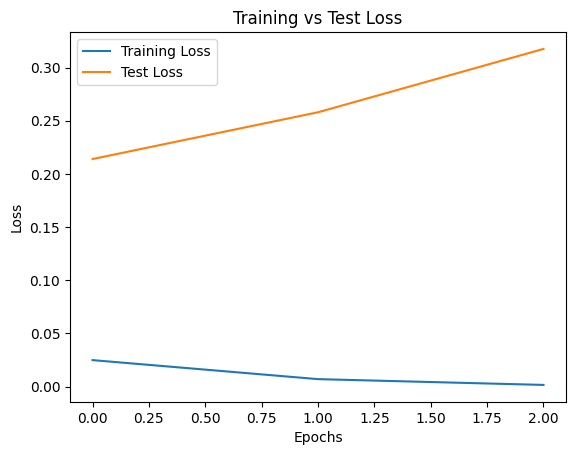

In [9]:
# Plotting training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation Loop


In [10]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc="Evaluating", leave=False):
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = model(texts, labels=labels)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average="binary"
    )
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
metrics_df = pd.DataFrame(
    [[accuracy, precision, recall, f1]],
    columns=["Accuracy", "Precision", "Recall", "F1 Score"],
)
print(metrics_df)
metrics_df.to_csv("../Model/Metrices/Evaluation_dataset_11430.csv", index=False)

Test Accuracy: 0.9458
Precision: 0.9515
Recall: 0.9398
F1 Score: 0.9456
   Accuracy  Precision    Recall  F1 Score
0  0.945757   0.951456  0.939843  0.945614
